# How to add breakpoints

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#human-in-the-loop). [Breakpoints](https://langchain-ai.github.io/langgraph/concepts/low_level/#breakpoints) are a common HIL interaction pattern, allowing the graph to stop at specific steps and seek human approval before proceeding (e.g., for sensitive actions).

Breakpoints are built on top of LangGraph [checkpoints](https://langchain-ai.github.io/langgraphjs/concepts/#checkpoints), which save the graph's state after each node execution. Checkpoints are saved in [threads](https://langchain-ai.github.io/langgraph/concepts/low_level/#threads) that preserve graph state and can be accessed after a graph has finished execution. This allows for graph execution to pause at specific points, await human approval, and then resume execution from the last checkpoint.

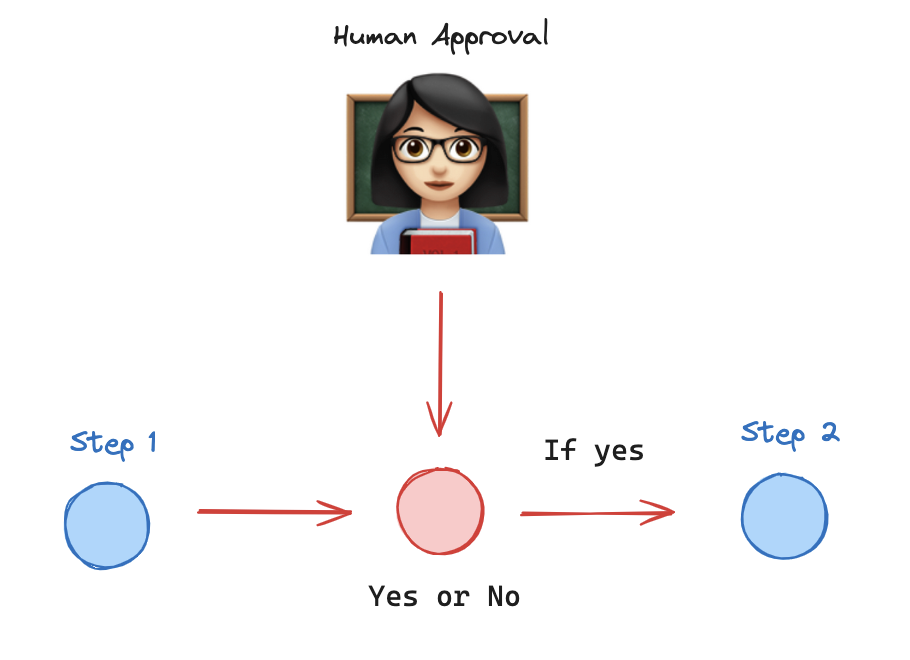

## Setup

First we need to install the packages required

```bash
npm install @langchain/langgraph @langchain/anthropic
```

Next, we need to set API keys for Anthropic (the LLM we will use)

```bash
export ANTHROPIC_API_KEY=your-api-key
```

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```

## Simple Usage

Let's look at very basic usage of this.

Below, we do two things:

1) We specify the [breakpoint](https://langchain-ai.github.io/langgraph/concepts/low_level/#breakpoints) using `interruptBefore` the specified step.

2) We set up a [checkpointer](https://langchain-ai.github.io/langgraphjs/concepts/#checkpoints) to save the state of the graph.

In [1]:
import { StateGraph, START, END } from "@langchain/langgraph";
import { MemorySaver } from "@langchain/langgraph";

type GraphState = {
    input: string;
}

const step1 = (state: GraphState): Partial<GraphState> => {
    console.log("---Step 1---");
    return state;
}

const step2 = (state: GraphState): Partial<GraphState> => {
    console.log("---Step 2---");
    return state;
}

const step3 = (state: GraphState): Partial<GraphState> => {
    console.log("---Step 3---");
    return state;
}


const builder = new StateGraph<GraphState>({
    channels: {
        input: null,
    }
})
    .addNode("step1", step1)
    .addNode("step2", step2)
    .addNode("step3", step3)
    .addEdge(START, "step1")
    .addEdge("step1", "step2")
    .addEdge("step2", "step3")
    .addEdge("step3", END);


// Set up memory
const memory = new MemorySaver()

// Add 
const graph = builder.compile({
    checkpointer: memory,
    interruptBefore: ["step3"]
});

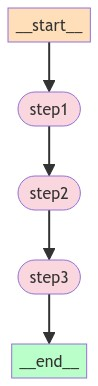

In [4]:
import * as tslab from "tslab";

const drawableGraph = graph.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

We create a [thread ID](https://langchain-ai.github.io/langgraph/concepts/low_level/#threads) for the checkpointer.

We run until step 3, as defined with `interruptBefore`. 

After the user input / approval, [we resume execution](https://langchain-ai.github.io/langgraph/concepts/low_level/#breakpoints) by invoking the graph with `null`. 

In [2]:
// Input
const initialInput = { input: "hello world" };

// Thread
const config = { configurable: { thread_id: "1" }, streamMode: "values" as const };

// Run the graph until the first interruption
for await (const event of await graph.stream(initialInput, config)) {
    console.log(`--- ${event.input} ---`);
}

// Will log when the graph is interrupted, after step 2.
console.log("---GRAPH INTERRUPTED---");

// If approved, continue the graph execution. We must pass `null` as
// the input here, or the graph will
for await (const event of await graph.stream(null, config)) {
    console.log(`--- ${event.input} ---`);
}


--- hello world ---
---Step 1---
--- hello world ---
---Step 2---
--- hello world ---
---GRAPH INTERRUPTED---
---Step 3---
--- hello world ---


## Agent

In the context of agents, breakpoints are useful to manually approve certain agent actions.
 
To show this, we will build a relatively simple ReAct-style agent that does tool calling. 

We'll add a breakpoint before the `action` node is called. 

In [1]:
// Set up the tool
import { ChatAnthropic } from "@langchain/anthropic";
import { tool } from "@langchain/core/tools";
import { StateGraph, START, END } from "@langchain/langgraph";
import { MemorySaver } from "@langchain/langgraph";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { BaseMessage, AIMessage } from "@langchain/core/messages";
import { z } from "zod";

interface MessagesState {
    messages: BaseMessage[];
}

const search = tool((input) => {
    return "It's sunny in San Francisco, but you better look out if you're a Gemini ðŸ˜ˆ.";
}, {
    name: "search",
    description: "Call to surf the web.",
    schema: z.string(),
})

const tools = [search]
const toolNode = new ToolNode<MessagesState>(tools)

// Set up the model
const model = new ChatAnthropic({ model: "claude-3-5-sonnet-20240620" })
const modelWithTools = model.bindTools(tools)


// Define nodes and conditional edges

// Define the function that determines whether to continue or not
function shouldContinue(state: MessagesState): "action" | typeof END {
    const lastMessage = state.messages[state.messages.length - 1];
    // If there is no function call, then we finish
    if (lastMessage && !(lastMessage as AIMessage).tool_calls?.length) {
        return END;
    }
    // Otherwise if there is, we continue
    return "action";
}

// Define the function that calls the model
async function callModel(state: MessagesState): Promise<Partial<MessagesState>> {
    const messages = state.messages;
    const response = await modelWithTools.invoke(messages);
    // We return an object with a messages property, because this will get added to the existing list
    return { messages: [response] };
}

// Define a new graph
const workflow = new StateGraph<MessagesState>({
    channels: {
        messages: {
            reducer: (a: any, b: any) => a.concat(b)
        },
    }
})
    // Define the two nodes we will cycle between
    .addNode("agent", callModel)
    .addNode("action", toolNode)
    // We now add a conditional edge
    .addConditionalEdges(
        // First, we define the start node. We use `agent`.
        // This means these are the edges taken after the `agent` node is called.
        "agent",
        // Next, we pass in the function that will determine which node is called next.
        shouldContinue
    )
    // We now add a normal edge from `action` to `agent`.
    // This means that after `action` is called, `agent` node is called next.
    .addEdge("action", "agent")
    // Set the entrypoint as `agent`
    // This means that this node is the first one called
    .addEdge(START, "agent");


// Setup memory
const memory = new MemorySaver();

// Finally, we compile it!
// This compiles it into a LangChain Runnable,
// meaning you can use it as you would any other runnable
const app = workflow.compile({
    checkpointer: memory,
    interruptBefore: ["action"]
});

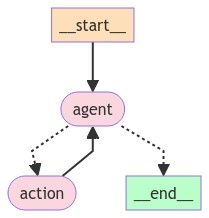

In [5]:
import * as tslab from "tslab";

const drawableGraph = app.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Interacting with the Agent

We can now interact with the agent.

We see that it stops before calling a tool, because `interruptBefore` is set before the `action` node.

In [2]:
import { HumanMessage } from "@langchain/core/messages";
// Input
const inputs = new HumanMessage("search for the weather in sf now");

// Thread
const config = { configurable: { thread_id: "3" }, streamMode: "values" as const };

for await (const event of await app.stream({
    messages: [inputs]
}, config)) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
search for the weather in sf now
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: "Certainly! I'll search for the current weather in San Francisco for you. Let me use the search function to find this information."
  },
  {
    type: 'tool_use',
    id: 'toolu_01Mo7noa5MEewbwAKyFDK8mg',
    name: 'search',
    input: { input: 'current weather in San Francisco' }
  }
]


**Resume**

We can now call the agent again with no inputs to continue.

This will run the tool as requested.

Running an interrupted graph with `null` in the inputs means to `proceed as if the interruption didn't occur.`

In [3]:
for await (const event of await app.stream(null, config)) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ tool Message (1) =================================
It's sunny in San Francisco, but you better look out if you're a Gemini ðŸ˜ˆ.
================================ ai Message (1) =================================
Based on the search results, I can provide you with information about the current weather in San Francisco:

The weather in San Francisco is currently sunny. This means it's a clear day with plenty of sunshine. It's a great day to be outdoors or enjoy activities in the city.

However, the search result also includes an unusual comment about Geminis. This appears to be unrelated to the weather and might be a joke or reference from the source. For accurate and detailed weather information, it would be best to check a reliable weather service or website.

Is there anything else you'd like to know about the weather in San Francisco or any other information you need?
